In [10]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 17-02-2022
# --- Last Modified: Thu 17 Feb 2022 07:03:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Visualize variation patterns.
"""
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import IPython
from PIL import Image as ImagePIL
from IPython.display import Image, display

import legacy

In [5]:
#navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00038-ffhq512-z_6-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_5-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000080.pkl'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00041-ffhq512-z_2-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_5-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000080.pkl'
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_resnet_ldimg_hw_mcont_neig100_ffhq512/00009-ffhq512-z_32-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_F-ldimg_T-ndup_1-sensor_resnet18-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_100-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch4/network-snapshot-000080.pkl'
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_neig60_ffhq512/00000-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_60-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1000-batch28/network-snapshot-000880.pkl'
device = torch.device('cuda:0')
with open(navigator_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False).to(device)

generator_pkl = 'ffhq512'
print('Loading generator networks from "%s"...' % generator_pkl)
resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

# gpu_ids = list(range(torch.cuda.device_count()))
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False).to(device) # type: ignore

Loading generator networks from "ffhq512"...


In [88]:
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/show_pt_pattern'
os.makedirs(outdir, exist_ok=True)

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
# def show_norm(img):
#     img = (img - img.min()) / (img.max() - img.min())
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# def show_after_tanh(img):
#     img = (img + 1) / 2.
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# def show(img):
#     show_norm(img)
#     #show_after_tanh(img)

# def clip_neg_show(img):
#     #img = img.abs()
#     img = img.relu()
#     show(img)

def imshow(img, surfix='0'):
    img = np.rint(img * 255).clip(0, 255).astype(np.uint8)
    img = ImagePIL.fromarray(np.transpose(img, (1,2,0)))
    img.save(os.path.join(outdir, f'tmp_{surfix}.jpg'))
    display(Image(filename=os.path.join(outdir, f'tmp_{surfix}.jpg')))

def show(img, im_range=[-1,1], **kwargs):
    img = (img - im_range[0]) / (im_range[1] - im_range[0])
    npimg = img.cpu().numpy()
    imshow(npimg, **kwargs)

In [86]:
def try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    z = torch.randn([1, G.z_dim], device=device)
    c = torch.randn([1, G.c_dim], device=device)
    w = G.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, used_dims[idx]] * var_scale_ls[idx]
    w_2 = w + dirs[:, used_dims[idx]] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G.synthesis(w_1, noise_mode='const')
    image_0 = G.synthesis(w, noise_mode='const')
    image_2 = G.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_0, image_2], dim=3)[0].cpu(), [-1,1], surfix=f'seed{seed}_dim{used_dims[idx]}_img')

torch.Size([30, 3, 512, 512])
tensor(7.2199, device='cuda:0') tensor(0.0176, device='cuda:0')
tensor(5.3508, device='cuda:0') tensor(0.0059, device='cuda:0')
tensor(3.1680, device='cuda:0') tensor(-3.1640, device='cuda:0')
dirs.shape torch.Size([1, 30, 16, 512])
4
torch.Size([1, 3, 512, 512])


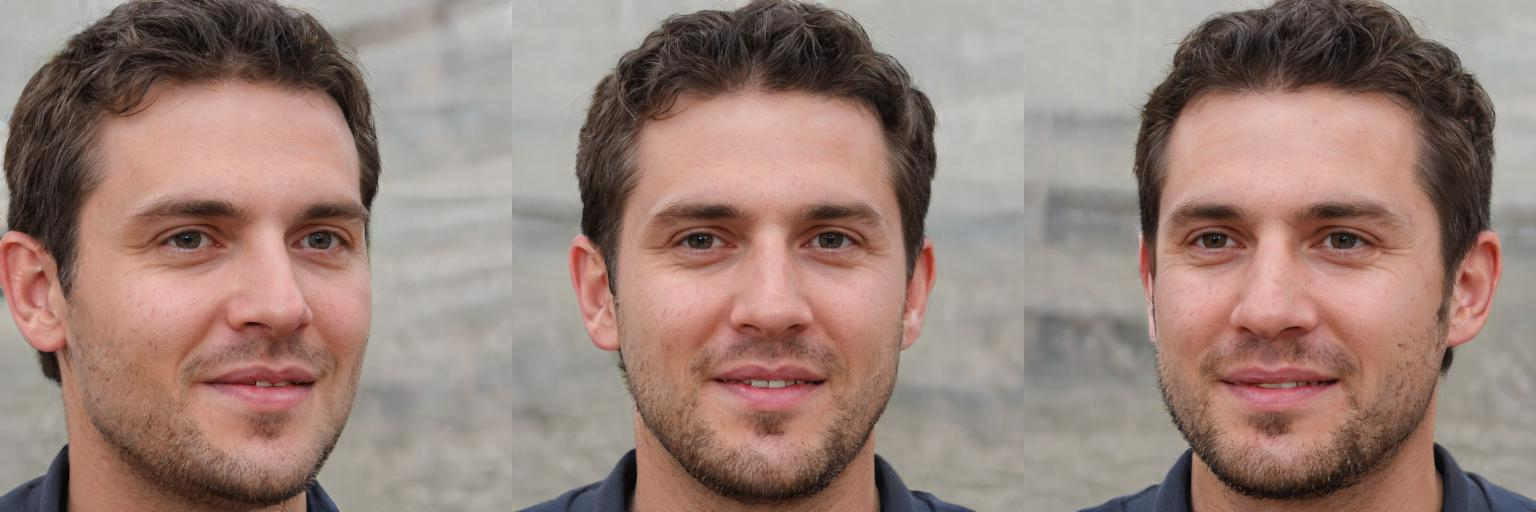

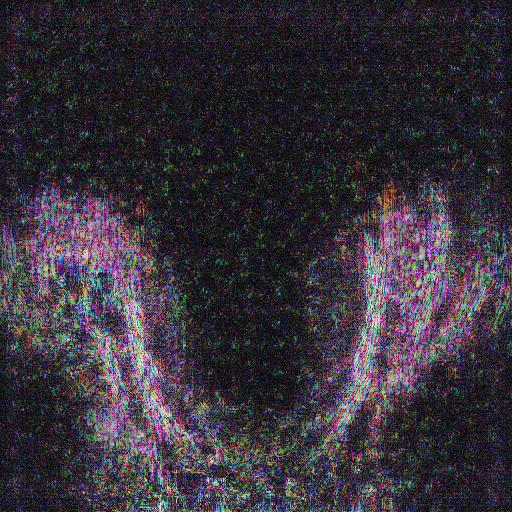

In [115]:
print(M.mem_dimgs.shape)
dimgs = M.mem_dimgs.unbind(dim=0)
print(dimgs[0].norm(dim=0).max(), dimgs[0].norm(dim=0).min())
print(dimgs[1].norm(dim=0).max(), dimgs[1].norm(dim=0).min())
print(dimgs[1].max(), dimgs[1].min())
used_dims = [0,2,4,5,9,10,11,12,14,16,18,19,22,24]
var_scale_ls = [1,0.5,0.5,0.4,0.5,0.3,0.4,0.3,1,0.5,0.2,0.5,0.4,0.5]

idx = 4
#for idx in range(14):
seed=idx
try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=seed)
to_show = dimgs[used_dims[idx]]
to_show = to_show.abs()
show(to_show, [to_show.min(), to_show.max()], surfix=f'dim{used_dims[idx]}_var')

# to_show = torch.cat(dimgs[-2:], dim=1).cpu()
#show(torch.cat([to_show.relu(), (-to_show).relu(), to_show.abs()], dim=2))
#show(to_show.relu()+(-to_show).relu())
#show(dimgs[-28].cpu().relu())
#clip_neg_show(torch.cat(dimgs[:2], dim=1).cpu())

In [60]:
navigator_pkl_0 = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_compare_ldimg_3ds/00000-3ds-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_64-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedES-neig_20-afc_3-nfc_3-atl_10-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg500-batch64/network-snapshot-000500.pkl'
navigator_pkl_1 = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_compare_ldimg_3ds/00001-3ds-z_10-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_64-dic_3-mir_T-ldimg_F-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedES-neig_20-afc_3-nfc_3-atl_10-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg500-batch64/network-snapshot-000500.pkl'

with open(navigator_pkl_0, 'rb') as f:
    resume_data = pickle.load(f)
    M_T = resume_data['M'].requires_grad_(False).to(device)
with open(navigator_pkl_1, 'rb') as f:
    resume_data = pickle.load(f)
    M_F = resume_data['M'].requires_grad_(False).to(device)
print(M_T.mem_dimgs.shape)
dimgs_T = M_T.mem_dimgs.unbind(dim=0)

torch.Size([10, 3, 64, 64])


torch.Size([10, 3, 64, 64])
torch.Size([10, 3, 64, 64])


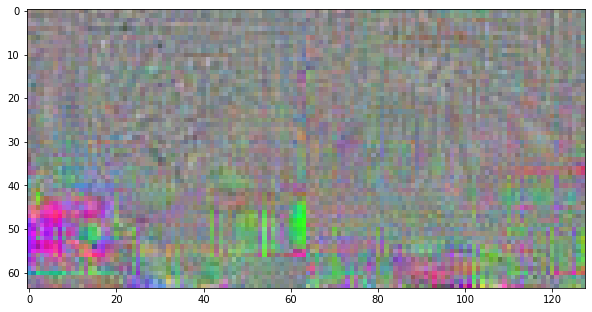

In [136]:
print(M_T.mem_dimgs.shape)
dimgs_T = M_T.mem_dimgs.unbind(dim=0)
print(M_F.mem_dimgs.shape)
dimgs_F = M_F.mem_dimgs.unbind(dim=0)
i = 5
to_show_T = dimgs_T[i].cpu()
to_show_F = dimgs_F[i].cpu()
#show(torch.cat((torch.tanh(to_show_T), torch.tanh(to_show_F)), dim=2))
#show(torch.cat((to_show_T.relu(), to_show_F.relu()), dim=2))
#show(torch.cat((to_show_T.abs(), to_show_F.abs()), dim=2))
show(torch.cat((to_show_T, to_show_F), dim=2))